<a href="https://colab.research.google.com/github/sverdoot/DL-in-NLP-course/blob/master/workshop%201/task5_negative_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Negative sampling

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling. In more detail: you should implement two ways of negative sampling.

## Vanilla negative sampling

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j, u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution, but it is better to use $P^{3/4}(w)$ (empirical results) and you can experiment with some other approaches (for example, try to use uniform distribution).

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

## Batch-transpose trick for negative sampling

But we can do better. Maybe we don't need to compute vectors for negative samples at all, because we already have a batch of training data and (hopefully) examples in the batch are highly decorrelated.

Let's assume we work with Skip-gram model.

Let $S$ be a batch of _L2-normalized_ word vectors `(batch_size, 2*window_size + 1, word_vector_dim)`.

```python
x = 0.0
for batch_idx in range(batch):
    w = S[batch_idx, :, :]
    x += np.sum(w.T @ w - 1.)

y = 0.0
for window_idx in range(window):
    b = S[:, window_idx, :]
    y += np.sum(b.T @ b)

loss = -x + y```

Think about this loss and compare it to vanilla negative sampling.

Implement word2vec with batch-transpose trick. Modify the formula, if needed.

If you are interested: [more info](https://www.tensorflow.org/extras/candidate_sampling.pdf) on other methods of candidate sampling.

**Results of this task** are the very same as in task 3, **plus**:
 * implement two models (one with vanilla negative sampling and the other with batch-transpose trick)
 * compare all of the models from tasks 3-5. In terms of time and number of iterations until convergence and the quality of the resulting vectors.
 * answer the questions

### Questions:
1. Explain the batch-transpose trick formula in your own words. How would you name x, y, w and b?
1. Should it be modified to serve as a word2vec loss? If yes, how?
1. Is it possible to do the same trick with CBOW model? If yes, how?
1. Does it matter how the batch is made in the case of batch-transpose trick? In the case of vanilla negative sampling?




## Answers:
  1. _
  1. _
  1. _
  1. _

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)
import numpy as np

import collections, math, os, random, zipfile
import numpy as np

from six.moves import urllib
from six.moves import xrange

url = 'http://mattmahoney.net/dc/'

UNK_TOKEN = '<UNK>'

import requests, os
from os.path import isfile

In [0]:
if not os.path.isfile('text8'):
    with open('data.zip', 'wb') as f:
        r = requests.get('http://mattmahoney.net/dc/text8.zip')
        f.write(r.content)
    !unzip 'data.zip' 

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = (f.read(f.namelist()[0]).split())
        data = list(map(lambda x: x.decode(), data))
    return data

!ls
#words = read_data('text8')
with open('text8') as f:
    words = f.read().split()

data.zip  sample_data  text8  tsne.png


In [0]:
def one_hot(batch, voc_size, batch_size=2):  
  if batch_size != 1:
    batch_onehot = torch.zeros(len(batch), voc_size)
    for i, e in enumerate(batch):
      for y in e:
        batch_onehot[i, int(y)] = batch_onehot[i, int(y)] + 1
  else:
    batch_onehot = torch.zeros(voc_size)
    for i in batch:
      batch_onehot[int(i)] = 1
      
  return batch_onehot

In [0]:
VOCAB_SIZE = 10000
full_data = words
freq_dict = collections.Counter(full_data)
no_rare_dict = freq_dict.most_common(VOCAB_SIZE)
min_freq = no_rare_dict[-1][1]
vocabulary = [x[0] for x in no_rare_dict]
vocabulary.append(UNK_TOKEN)

data = []
for i, word in enumerate(full_data):
  if freq_dict[word] > min_freq:
    data.append(word)
  else:
    data.append(UNK_TOKEN)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

data_idx = 0

class Batcher:
  
  def __init__(self, batch_size, window_size, data, data_idx=0):
    self.batch_size = batch_size
    self.window_size = window_size
    self.data = data
    
  def __iter__(self):
  
    return self

  def __next__(self, data_idx_=None):
    window_size = self.window_size
    batch_size = self.batch_size
    data = self.data
    global data_idx
    batch = []
    labels = [] 
  
    context = collections.deque(maxlen=2 * window_size + 1)
  
    for _ in range(2 * window_size + 1):
      context.append(word2idx[data[data_idx]])
      data_idx = (data_idx + 1) % len(data)
  
    for i in range(batch_size):
      batch.append([context[j] for  j in list(range(window_size)) + list(range(window_size + 1, 2 * window_size + 1))])
      labels.append(context[window_size])
      context.append(word2idx[data[data_idx]])
      data_idx = (data_idx + 1) % len(data)
    
    return (batch, labels)

## Part 1

In [0]:
class Model(nn.Module):
  def __init__(self, vocab_size, output_size, window_size, k=20, weights=None):
    super(Model, self).__init__()
    self.vocab_size = vocab_size
    self.weights = weights
    if self.weights is not None:
      assert min(self.weights) >= 0, "Each weight should be >= 0"
      self.weights = torch.autograd.Variable(torch.from_numpy(weights)).float()
    self.k = k
    self.out_size = output_size
    
    self.in_emb = nn.Embedding(vocab_size, output_size)
    #lf.out_emb = nn.Embedding(vocab_size, output_size)
    self.log_sigmoid = nn.LogSigmoid()
    
    initrange = (2.0 / (vocab_size + output_size)) ** 0.5  # Xavier init
    self.in_emb.weight.data.uniform_(-initrange, initrange)
    #elf.out_emb.weight.data.uniform_(-0, 0)
  
  def forward(self, batch, labels):
    k = self.k
    batch_t = torch.LongTensor(batch).to(device=device)
    [batch_size, window_size] = batch_t.size()
    batch_t = batch_t.sum(1) / (2 * window_size)

    in_vec = self.in_emb(batch_t).to(device=device, dtype=dtype)
    out_vec = self.in_emb(torch.LongTensor(labels).to(device=device)).to(device=device, dtype=dtype)

    if self.weights is not None:
      nwords = torch.multinomial(self.weights, batch_size * self.k, replacement=True).view(batch_size, -1)
    else:
      nwords = torch.Tensor(batch_size, self.k).uniform_(0, self.vocab_size - 1).to(device=device, dtype=torch.long)
    noise = self.in_emb(nwords).to(device=device, dtype=dtype).neg()
    ploss = self.log_sigmoid(torch.bmm(out_vec.unsqueeze(1), in_vec.unsqueeze(2)).squeeze())
    nloss = self.log_sigmoid(torch.bmm(noise.view(batch_size, self.k, self.out_size), in_vec.unsqueeze(2)).squeeze()).sum(1)
    return -(ploss + nloss).mean()
  
  def predict(self, inputs):
    return self.in_emb(torch.tensor(inputs).to(device=device, dtype=torch.long))

In [0]:
part_data = data[:1000000]
vocab_size = len(vocabulary)
batch_size = 4000
output_size = 100
window_size = 3
print_every = 100

USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

weights = np.array([freq_dict[x] for x in vocabulary]) ** (3 / 4)
weights = weights / weights.sum()
model = Model(vocab_size=vocab_size, output_size=output_size, window_size=window_size, k=20)
model = model.to(device=device)
data_idx = 0
batcher = Batcher(batch_size, window_size, part_data)
build_batch = iter(batcher)

losses = []
train_time = 0
it_per_ep = len(part_data) // batch_size

using device: cuda


In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
s = time.clock()
for e in range(30000):
    batch, label = next(build_batch)
    model.train() 
    loss = model(batch, label).to(device=device, dtype=dtype)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if e % 100 == 0:
        train_time = train_time + time.clock() - s
        s = time.clock()
        print('Iteration %d, loss = %lg' % (e, sum(losses[-100:])))
        print()

In [0]:
print('Training time: {}'.format(train_time // 1))

Training time: 907.0


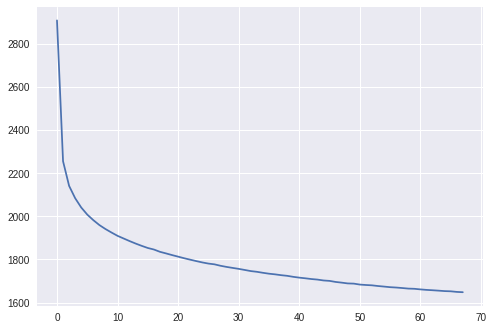

In [0]:
import matplotlib.pyplot as plt
it_per_ep = len(part_data) // batch_size
loss_ep = [sum(losses[i * it_per_ep : i * it_per_ep + it_per_ep]) for i in range(len(losses) // it_per_ep)]
plt.plot(loss_ep)

In [0]:
word2vec = lambda x: model.predict([word2idx[x]])[0].to(device=device, dtype=torch.float).detach().cpu().numpy()
idx2vec = lambda x: model.predict([x])[0].to(device=device, dtype=torch.float).detach().cpu().numpy()

In [0]:
from matplotlib import pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

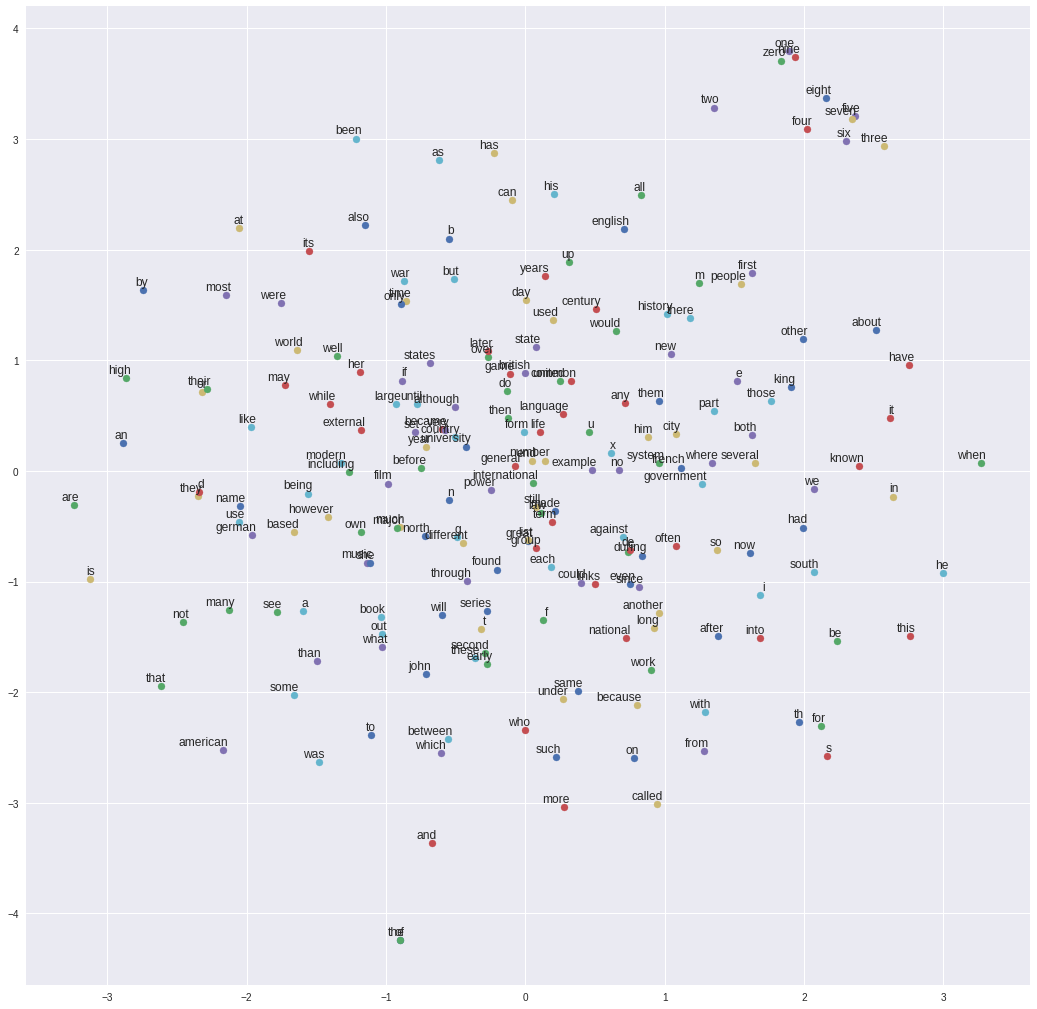

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30,n_components=2, init='pca')
plot_only = 200
final_embeddings = []
final_embeddings = [idx2vec(i) for i in range(plot_only)]
low_dim_embs = tsne.fit_transform(np.array(final_embeddings))
labels = [idx2word[i] for i in range(plot_only)]

plot_with_labels(low_dim_embs, labels)

In [0]:
def cosine_similarity(word1, word2, word2vec):
  vec1 = word2vec(word1)
  vec2 = word2vec(word2)
  return np.dot(vec1, vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2)

In [0]:
def nearest_neighbours(words, vocabulary, word2vec, num_neighb=5):
  word_neighb = {}
  for word1 in words:
    similarity = {}
    for word2 in vocabulary:
      similarity[word2] = cosine_similarity(word1, word2, word2vec)
    f = lambda x: similarity[x]
    most_similar = list(similarity.keys())
    most_similar.sort(reverse=True, key=f)
    word_neighb[word1] = most_similar[:num_neighb]
  return word_neighb

In [0]:
nearest_neighbours(['american', 'he', 'year', 'world', 'north', 'may'], vocabulary, word2vec)

{'american': ['american', 'democracy', 'doctrine', 'flow', 'problem'],
 'he': ['he', 'significant', 'p', 'songs', 'international'],
 'may': ['may', 'kingdom', 'local', 'fact', 'health'],
 'north': ['north', 'developed', 'different', 'language', 'major'],
 'world': ['world', 'while', 'fact', 'democracy', 'small'],
 'year': ['year', 'player', 'claim', 'war', 'time']}

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

#torch.save(model.state_dict(), '/content/drive/My Drive/model_task5_1')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Part 2

Oops, it seems I haven't done it..